In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fp1 = r"C:\SEM6\PCPO\p6\cat.jpg"  # 1280 x 781
fp2 = r"C:\SEM6\PCPO\p6\chessboard.jpg"  # 1237 x 1235

In [3]:
def harris_f(filepath, threshold=0.5, radius=1):
    """
    implementacja detectora wierzchołków Harrisa na trchę niższym poziomie niż cv2.cornerHarris()
    - nie działa dobrze... (threshold 0.999 i 0.999999999999 nie ma różnicy, i tak dużo punktów zostaje)
    - nie chce mi się tego naprawiać, taki kod dostaliśmy
    - można dodać argumenty określające wymiary kernelów sobelx, sobely, filtrGaussa - nie chce mi się
    - działa fatalnie (_f), nie używać
    """
    img = cv2.imread(filepath)
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Maska filtru kierunkowego Sobel’a (x)
    sobelX = np.array((
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]), dtype="int32")
    # Maska filtru kierunkowego Sobel’a (y)
    sobelY = np.array((
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]), dtype="int32")
    # Maska filtru Gaussa o wymiarach 3x3
    maskaFiltruGaussa = np.array((
        [1 / 16, 2 / 16, 1 / 16],
        [2 / 16, 4 / 16, 2 / 16],
        [1 / 16, 2 / 16, 1 / 16]), dtype="float64")
    dx = cv2.filter2D(src=img_grey, ddepth=-1, kernel=sobelX)
    dy = cv2.filter2D(src=img_grey, ddepth=-1, kernel=sobelY)
    dx2 = np.square(dx)
    dy2 = np.square(dy)
    dxdy = dx * dy
    g_dx2 = cv2.filter2D(dx2, -1, maskaFiltruGaussa)
    g_dy2 = cv2.filter2D(dy2, -1, maskaFiltruGaussa)
    g_dxdy = cv2.filter2D(dxdy, -1, maskaFiltruGaussa)
    harris = g_dx2 * g_dy2 - np.square(g_dxdy) - 0.04 * np.square(g_dx2 + g_dy2)  # r(harris) = det - k*(trace**2)
    cv2.normalize(harris, harris, 0, 1, cv2.NORM_MINMAX)
    loc = np.where(harris >= threshold)
    # Zaznaczenie na obrazie punktów w postaci okręgów
    for pt in zip(*loc[::-1]):
        cv2.circle(img, pt, radius, (0, 0, 255), -1)
    cv2.imshow(f'Punkty wykryte detektorem Harrisa fffff threshold = {threshold}', img)
    if cv2.waitKey(0) & 0xff == 27:
        cv2.destroyAllWindows()
    return img, loc

In [4]:
def harris(filepath, blockSize=2, ksize=3, k=0.004):
    """
    # blockSize (np. 2) - Jest to wielkość sąsiedztwa brana pod uwagę przy wykrywaniu narożników
    blockSize - It is the size of neighbourhood considered for corner detection
    # ksize (np. 3) - Parametr wielkości maksi używanej pochodnej Sobela.
    ksize - Aperture parameter of the Sobel derivative used.
    # k (np. 0.004) - Parametr wolny w równaniu detektora Harris (0.004 – 0.006)
    k - Harris detector free parameter in the equation.
    
    https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html
    """
    img = cv2.imread(filepath)
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_grey = np.float32(img_grey)
    harris = cv2.cornerHarris(img_grey, blockSize, ksize, k)
    img[harris > 0.1 * harris.max()] = [0, 0, 255]
    # co tu się dzieje? co oznacza harris max? zo zwraca harris? czemu to nie jest wyjaśniane.... jprdlsvd kjbsdbkgfjjkdfa
    cv2.imshow('Punkty wykryte detektorem Harrisa', img)
    if cv2.waitKey(0) & 0xff == 27:
        cv2.destroyAllWindows()
    return img  #, harris? jak dostac wsp... 

In [5]:
def harris_extended(filepath, blockSize=2, ksize=3, k=0.004):
    zdjecie = cv2.imread(filepath)
    szareZdjecie = cv2.cvtColor(zdjecie, cv2.COLOR_BGR2GRAY)  # Konwersja obrazu do postaci zdjęcia w odcieniach szarości
    # find Harris corners
    szareZdjecie = np.float32(szareZdjecie)
    harris = cv2.cornerHarris(szareZdjecie, blockSize, ksize, k)
    harris = cv2.dilate(harris, None)
    ret, dst = cv2.threshold(harris, 0.01 * harris.max(), 255, 0)
    dst = np.uint8(dst)
    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(szareZdjecie, np.float32(centroids), (5, 5), (-1, -1), criteria)
    # Now draw them
    res = np.hstack((centroids, corners))
    res = np.int0(res)
    zdjecie[res[:, 1], res[:, 0]] = [0, 0, 255]
    zdjecie[res[:, 3], res[:, 2]] = [0, 255, 0]
    cv2.imshow('Punkty wykryte detektorem Harrisa', zdjecie)
    if cv2.waitKey(0) & 0xff == 27:
        cv2.destroyAllWindows()
    return zdjecie #, res

In [6]:
def fast_stock(filepath):
    img = cv2.imread(filepath)
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Inicjalizacja detektora FAST z wartościami domyślnymi funkcji
    fast = cv2.FastFeatureDetector.create()
    # Wykrycie punktów charakterystycznych (keypoints)
    kp = fast.detect(img_grey, None)
    # Narysowanie punktów charakterystycznych (keypoints)
    img2 = cv2.drawKeypoints(img_grey, kp, None, color=(255, 0, 0))
    # Wyświetlenie parametrów funkcji
    print("Threshold: ", fast.getThreshold())
    print("nonmaxSuppression: ", fast.getNonmaxSuppression())
    print("neighborhood: ", fast.getType())
    print("Total Keypoints without nonmaxSuppression: ", len(kp))
    cv2.imshow('Punkty wykryte algorytmem Fast', img2)
    if cv2.waitKey(0) & 0xff == 27:
        cv2.destroyAllWindows()
    return img2 #, 

In [7]:
def fast(filepath, threshold=10, nonmaxSuppresion=True, type=cv2.FAST_FEATURE_DETECTOR_TYPE_9_16):
    """
    FAST: Features from  Accelerated  Segment  Test
    cv2.FAST_FEATURE_DETECTOR_TYPE_9_16, cv2.FAST_FEATURE_DETECTOR_TYPE_5_8, cv2.FAST_FEATURE_DETECTOR_TYPE_7_12
    """
    img = cv2.imread(filepath)
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    fast = cv2.FastFeatureDetector.create(threshold, nonmaxSuppresion, type)
    keypoints = fast.detect(img_grey, None)
    img2 = cv2.drawKeypoints(img_grey, keypoints, None, color=(255, 0, 0))
    cv2.imshow('Punkty wykryte algorytmem Fast', img2)
    if cv2.waitKey(0) & 0xff == 27:
        cv2.destroyAllWindows()
    return img2, keypoints # . . .

In [8]:
# img, pts = harris_f(fp2, threshold=0.999, radius=1)
# print(pts)
# print(len(pts[0]),len(pts[1]))

In [9]:
# harris(fp1, blockSize=10, ksize=1);

In [10]:
# harris_extended(fp1);

In [11]:
# fast_stock(fp1);

In [12]:
fast(fp1, threshold=120, nonmaxSuppresion=False);

# Ehh... Po co robić wykresy dla harris_f? przeciez to zle dziala.......,gsdfklnagsfbdkjprdlljnd sfbagkl

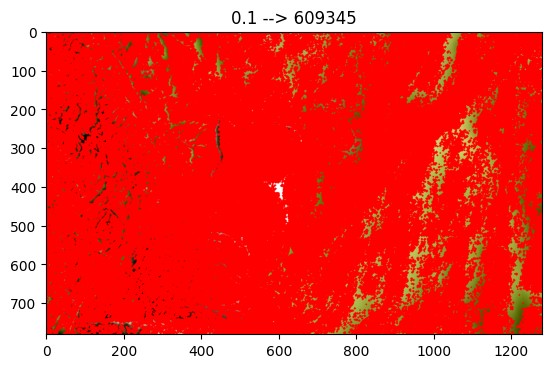

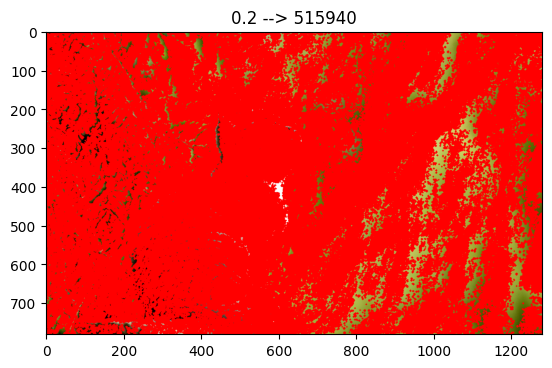

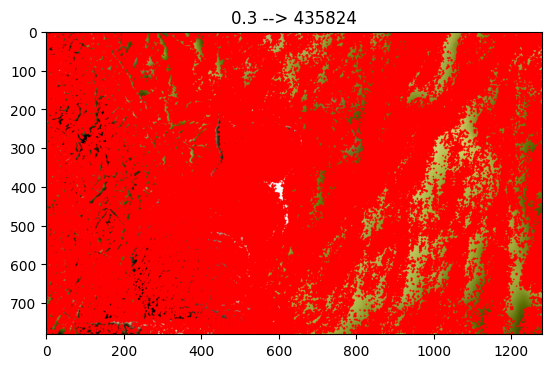

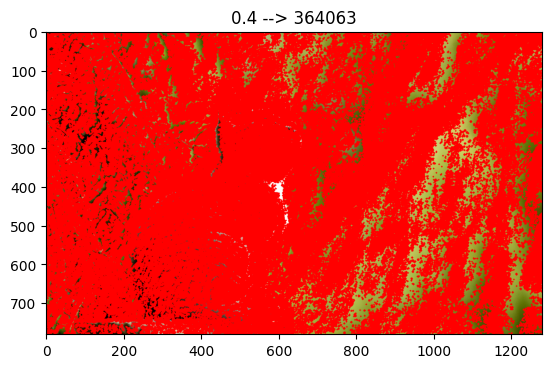

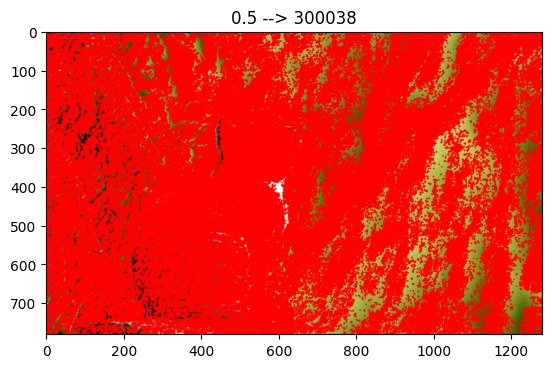

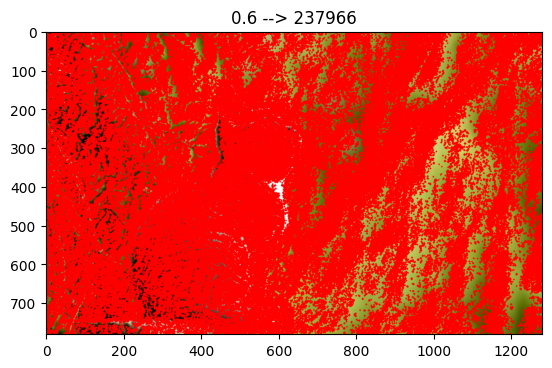

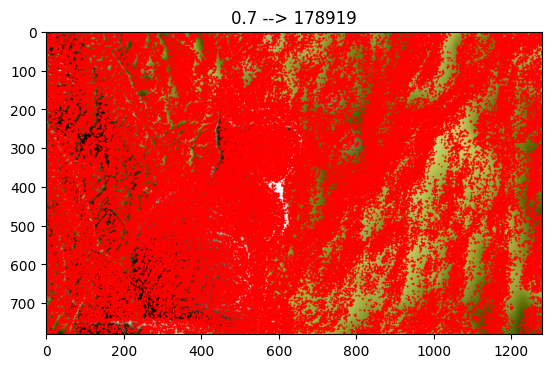

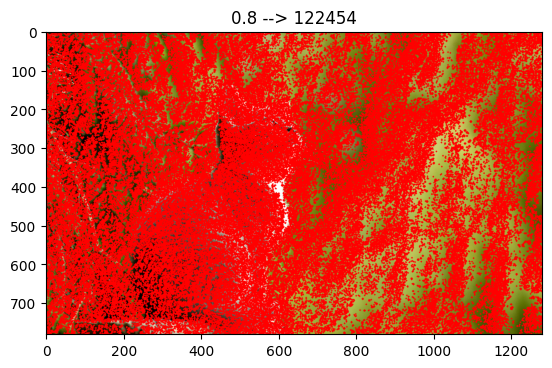

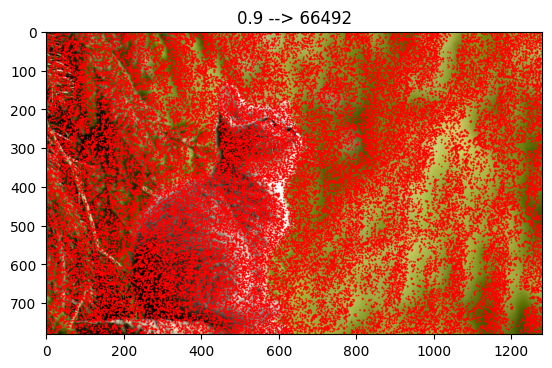

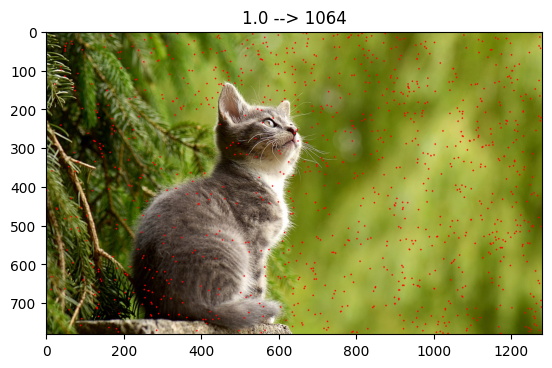

In [13]:
threshold_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999999999999999999]
detected_points = []
for t in threshold_values:
    img, pts = harris_f(fp1, threshold=t, radius=2)
    no_pts = len(pts[0])
    detected_points.append(no_pts)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{t} --> {no_pts}")
    plt.show()

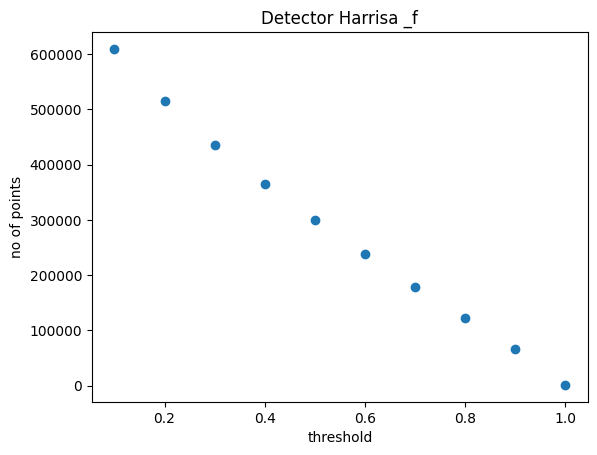

In [14]:
plt.scatter(threshold_values, detected_points)
plt.xlabel("threshold")
plt.ylabel("no of points")
plt.title("Detector Harrisa _f")
plt.show()

# FAST różne parametry threshold

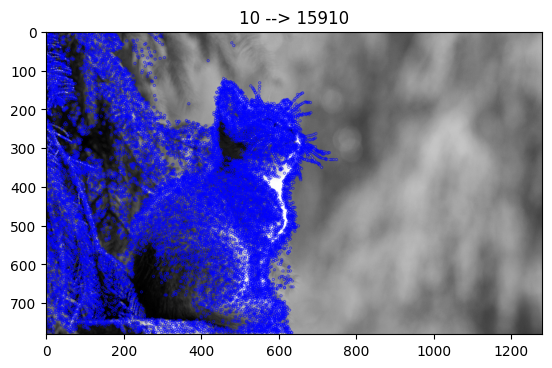

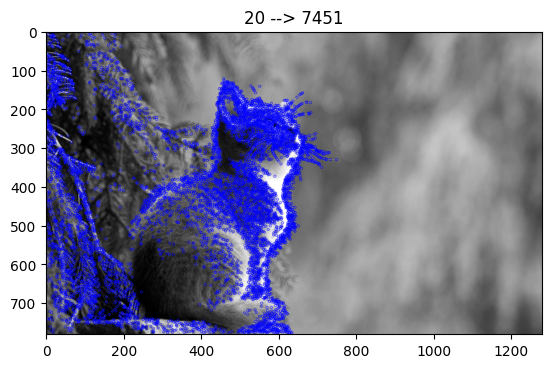

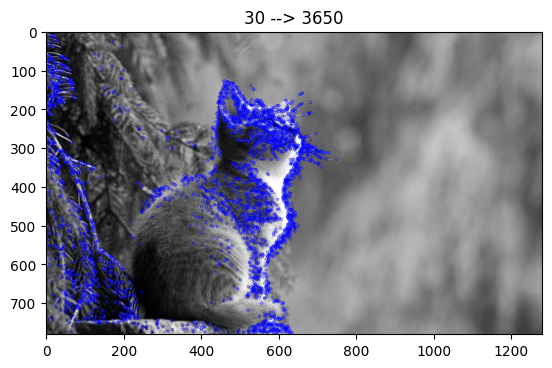

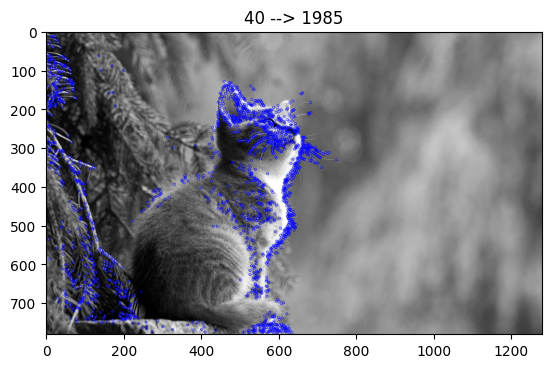

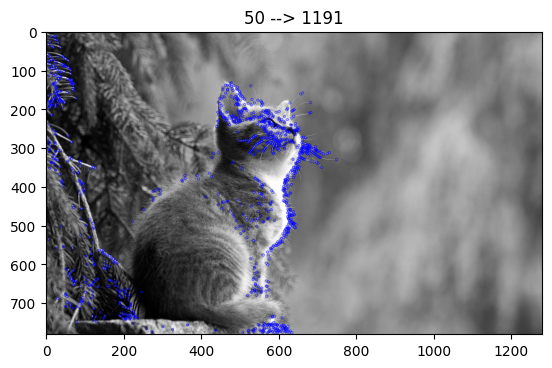

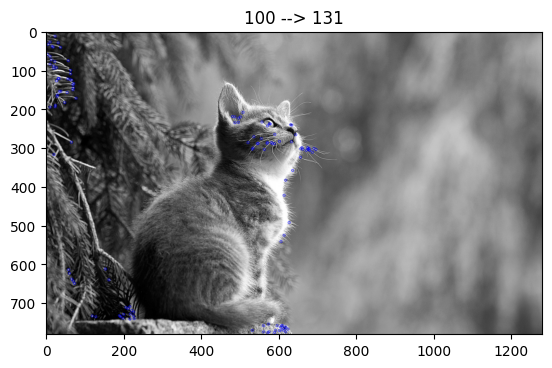

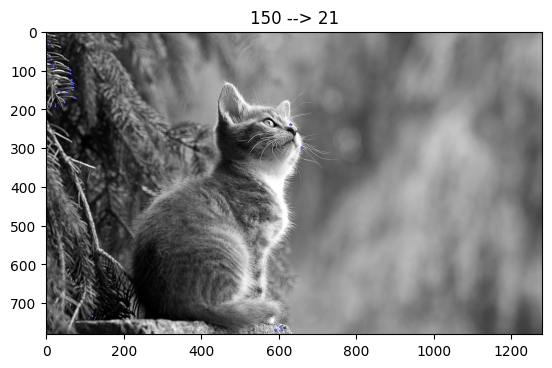

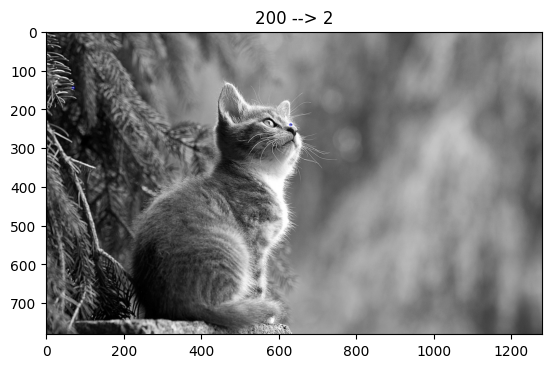

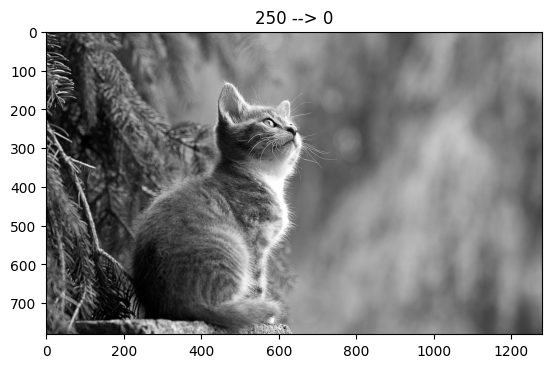

In [15]:
threshold_values = [10, 20, 30, 40, 50, 100, 150, 200, 250]
detected_points = []
for t in threshold_values:
    img, pts = fast(fp1, threshold=t, nonmaxSuppresion=True)
    no_pts = len(pts)
    detected_points.append(no_pts)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{t} --> {no_pts}")
    plt.show()

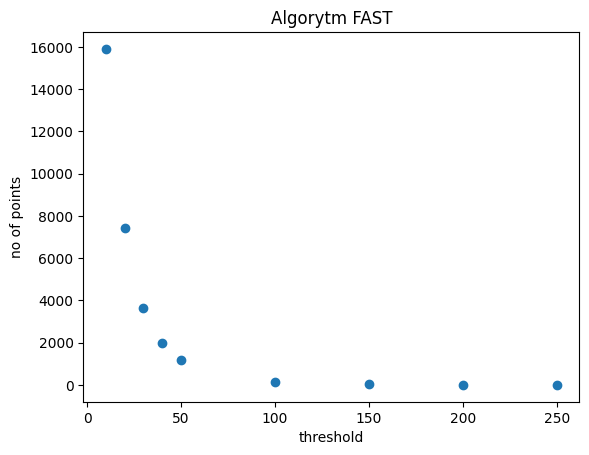

In [16]:
plt.scatter(threshold_values, detected_points)
plt.xlabel("threshold")
plt.ylabel("no of points")
plt.title("Algorytm FAST")
plt.show()